In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Kernel Density Estimate of Species Distributions
This shows an example of a neighbors-based query (in particular a kernel density estimate) on geospatial data, using a Ball Tree built upon the Haversine distance metric – i.e. distances over points in latitude/longitude. The dataset is provided by Phillips et. al. (2006). If available, the example uses basemap to plot the coast lines and national boundaries of South America.

This example does not perform any learning over the data (see Species distribution modeling for an example of classification based on the attributes in this dataset). It simply shows the kernel density estimate of observed data points in geospatial coordinates.

The two species are:

“Bradypus variegatus” , the Brown-throated Sloth.

“Microryzomys minutus” , also known as the Forest Small Rice Rat, a rodent that lives in Peru, Colombia, Ecuador, Peru, and Venezuela.

References
“Maximum entropy modeling of species geographic distributions” S. J. Phillips, R. P. Anderson, R. E. Schapire - Ecological Modelling, 190:231-259, 2006.

 - computing KDE in spherical coordinates
 - plot coastlines from coverage
 - computing KDE in spherical coordinates
 - plot coastlines from coverage


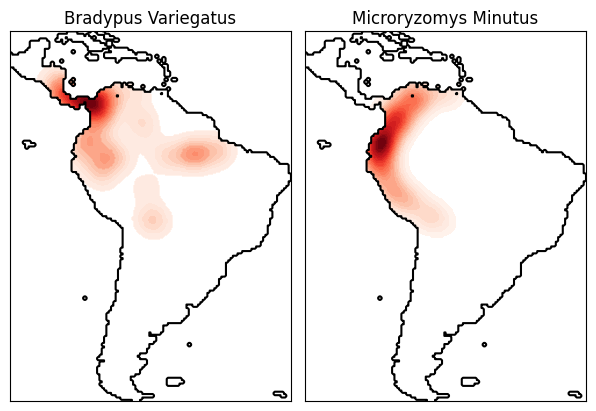

In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap

    basemap = True
except ImportError:
    basemap = False


def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ["Bradypus Variegatus", "Microryzomys Minutus"]

Xtrain = np.vstack([data["train"]["dd lat"], data["train"]["dd long"]]).T
ytrain = np.array(
    [d.decode("ascii").startswith("micro") for d in data["train"]["species"]],
    dtype="int",
)
Xtrain *= np.pi / 180.0  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.0

# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(
        bandwidth=0.04, metric="haversine", kernel="gaussian", algorithm="ball_tree"
    )
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype="int")
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(
            projection="cyl",
            llcrnrlat=Y.min(),
            urcrnrlat=Y.max(),
            llcrnrlon=X.min(),
            urcrnrlon=X.max(),
            resolution="c",
        )
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(
            X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
        )
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()

# Nearest Neighbors Classification
This example shows how to use KNeighborsClassifier. We train such a classifier on the iris dataset and observe the difference of the decision boundary obtained with regards to the parameter weights. 

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris(as_frame=True)
X = iris.data[["sepal length (cm)", "sepal width (cm)"]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# K-nearest neighbors classifier
We want to use a k-nearest neighbors classifier considering a neighborhood of 11 data points. Since our k-nearest neighbors model uses euclidean distance to find the nearest neighbors, it is therefore important to scale the data beforehand. Refer to the example entitled Importance of Feature Scaling for more detailed information.

Thus, we use a Pipeline to chain a scaler before to use our classifier.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
)

# Decision boundary
Now, we fit two classifiers with different values of the parameter weights. We plot the decision boundary of each classifier as well as the original dataset to observe the difference.

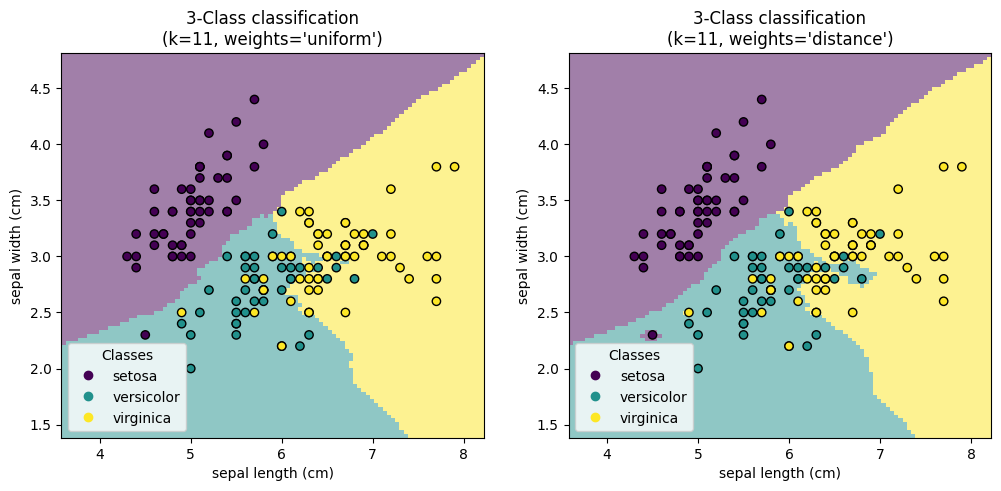

In [4]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

# Nearest Neighbors regression
Demonstrate the resolution of a regression problem using a k-Nearest Neighbor and the interpolation of the target using both barycenter and constant weights.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import neighbors

rng = np.random.RandomState(0)
X_train = np.sort(5 * rng.rand(40, 1), axis=0)
X_test = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X_train).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

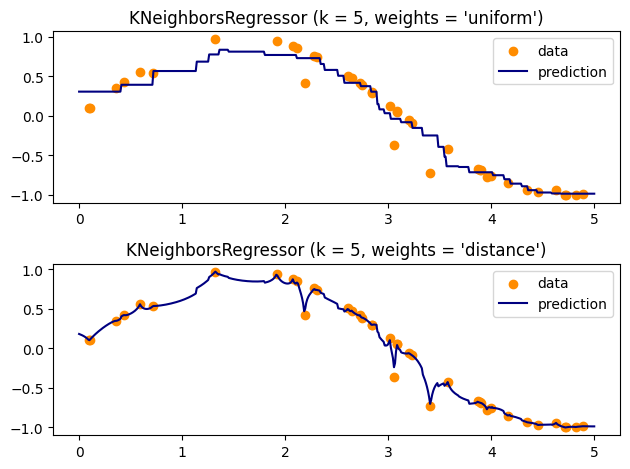

In [6]:
n_neighbors = 5

for i, weights in enumerate(["uniform", "distance"]):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(X_train, y).predict(X_test)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X_train, y, color="darkorange", label="data")
    plt.plot(X_test, y_, color="navy", label="prediction")
    plt.axis("tight")
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.tight_layout()
plt.show()

# Face completion with a multi-output estimators
This example shows the use of multi-output estimator to complete images. The goal is to predict the lower half of a face given its upper half.

The first column of images shows true faces. The next columns illustrate how extremely randomized trees, k nearest neighbors, linear regression and ridge regression complete the lower half of those faces.

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


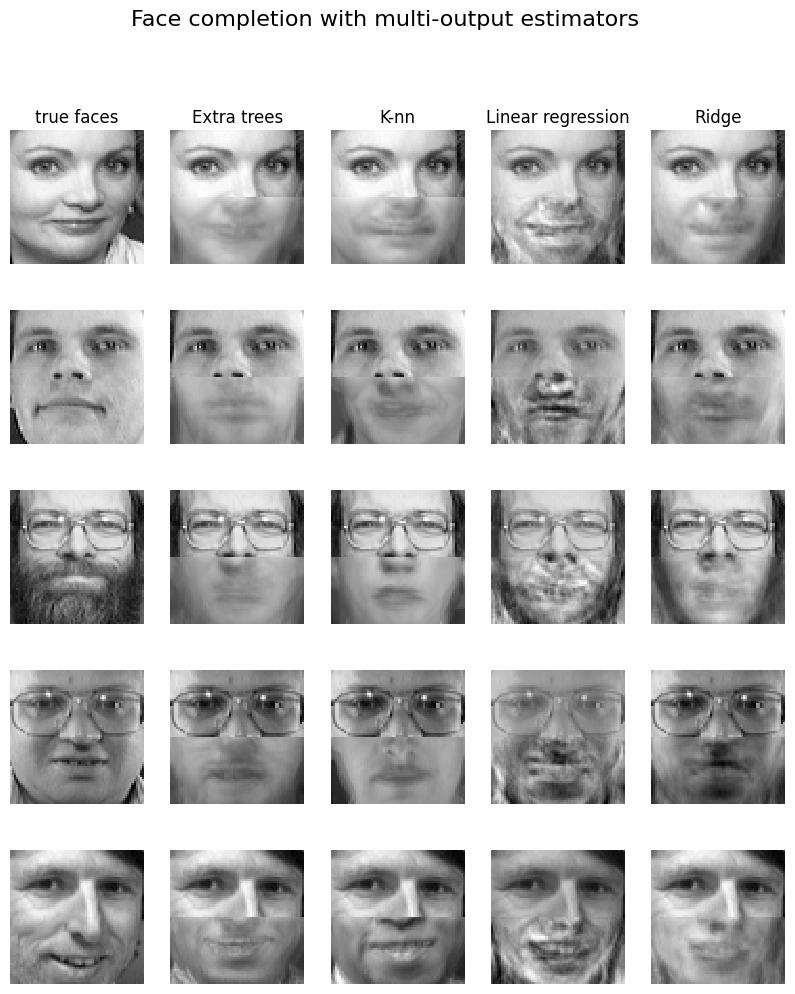

In [7]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils.validation import check_random_state

# Load the faces datasets
data, targets = fetch_olivetti_faces(return_X_y=True)

train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces,))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, : (n_pixels + 1) // 2]
# Lower half of the faces
y_train = train[:, n_pixels // 2 :]
X_test = test[:, : (n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2 :]

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=10, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)

# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2.0 * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(
        true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest"
    )

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j, title=est)

        sub.axis("off")
        sub.imshow(
            completed_face.reshape(image_shape),
            cmap=plt.cm.gray,
            interpolation="nearest",
        )

plt.show()